# Quora Question Pairs

因为时间匆忙，笔者一开始就放弃了深度模型，基本思路是通过尽可能多地提取特征，争取用XGBoost集成也能有基本的效果。

**环境说明**

- 操作系统：Windows 10
- 语言：Python 3
- 解释器：Kaggle Kernel

**作业流程**

- 数据清洗
- 特征提取
- 模型训练

**最终得分与排名**

Public Scores: 0.16898

Private Scores: 0.17358

Public Rank: 626

Private Rank: 626

<center>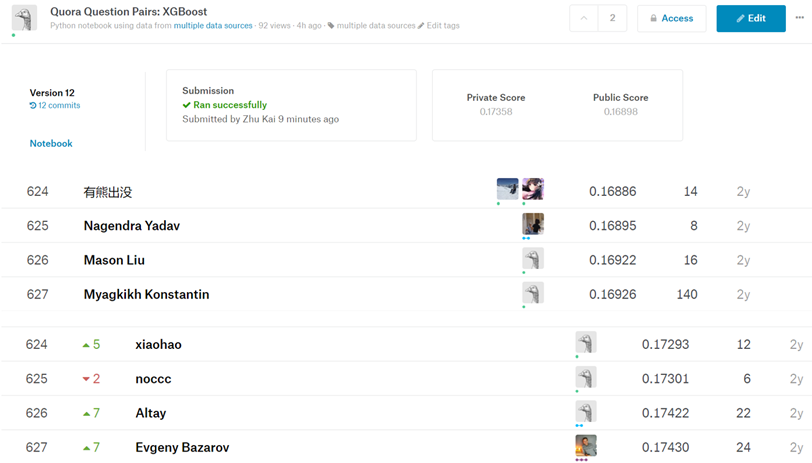</center>

Public和Private榜上的得分也可以在[Quora Question Pairs: XGBoost](https://www.kaggle.com/benjaminkz/quora-question-pairs-xgboost)上查看。

In [ ]:
import os
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
from string import punctuation

# 1 数据清洗

本次任务的数据清洗工作较为繁重，为了照顾到后续特征提取的不同需要，本文生成了以下多个版本的训练集和测试集：

- train_orig/test_orig：在原始数据集的基础上，填补缺失问题，对部分同义词进行转换，并所有标点符号和部分特殊符号
- train_stop/test_stop：在train_orig/test_orig的基础上，去除停用词
- train_stem/test_stem：在train_stop/test_stop的基础上，提取单词词根
- train_lem/test_lem：在train_stop/test_stop的基础上，还原单词的原型

特征提取将选取一个或多个版本的训练集和测试集进行。通过Kaggle Kernel完成以上清洗大概需要35min。

## train_orig/test_orig

In [ ]:
train_orig = pd.read_csv("../input/quora-question-pairs/train.csv")
test_orig = pd.read_csv("../input/quora-question-pairs/test.csv")
train_orig.head()

In [ ]:
print(train_orig.isnull().sum())
print(test_orig.isnull().sum())

训练集和测试集中部分问题是空值，本文用一个空格字符串填充。

In [ ]:
train_orig = train_orig.fillna(" ")
test_orig = test_orig.fillna(" ")


原始数据集中存在许多同义表述，以及标点符号和杂乱的特殊符号。本文首先将所有文本转换为小写，其次把常见缩写替换成没有缩写的形式，再次去除标点符号和特殊符号，最后是从其他kernel上收集到的单词替换。定义common_words_transformation_remove_punctuation函数来完成以上过程，得到第一层样本train_orig/test_orig。

In [ ]:
def common_words_transformation_remove_punctuation(text):
    
    text = text.lower()
    
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"when's", "when is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"there's", "there is", text)

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\'s", " ", text)  # 除了上面的特殊情况外，“\'s”只能表示所有格，应替换成“ ”
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " america ", text)
    text = re.sub(r" u s ", " america ", text)
    text = re.sub(r" uk ", " england ", text)
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text)
    text = re.sub(r" ds ", " data science ", text)
    text = re.sub(r" ee ", " electronic engineering ", text)
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iphone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the us", "america", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r"\0s", "0", text)
    
    text = "".join([c for c in text if c not in punctuation])
        
    return text

train_orig["question1"] = train_orig["question1"].apply(common_words_transformation_remove_punctuation)
train_orig["question2"] = train_orig["question2"].apply(common_words_transformation_remove_punctuation)
test_orig["question1"] = test_orig["question1"].apply(common_words_transformation_remove_punctuation)
test_orig["question2"] = test_orig["question2"].apply(common_words_transformation_remove_punctuation)
train_orig.to_csv("train_orig.csv", index = False)
test_orig.to_csv("test_orig.csv", index = False)
train_orig.head()

## train_stop/test_stop

NLTK是自然语言处理当中最为常用的库，其中的stopwords已整理出了多个语种的停用词。

In [ ]:
stopwords.words("english")

下面定义remove_stopwords函数完成对停用词的清理，得到train_stop/test_stop。

In [ ]:
def remove_stopwords(text):
    stops = set(stopwords.words("english"))
    text = word_tokenize(text)
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

train_stop, test_stop = train_orig.copy(deep = True), test_orig.copy(deep = True)
train_stop["question1"] = train_stop["question1"].apply(remove_stopwords)
train_stop["question2"] = train_stop["question2"].apply(remove_stopwords)
test_stop["question1"] = test_stop["question1"].apply(remove_stopwords)
test_stop["question2"] = test_stop["question2"].apply(remove_stopwords)
train_stop.to_csv("train_stop.csv", index = False)
test_stop.to_csv("test_stop.csv", index = False)
train_stop.head()

## train_stem/test_stem

使用NLTK库中的SnowballStemmer提取词根，得到train_stem/test_stem。

In [ ]:
def stem_words(text):
    text = word_tokenize(text)
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

train_stem, test_stem = train_stop.copy(deep = True), test_stop.copy(deep = True)
train_stem["question1"] = train_stem["question1"].apply(stem_words)
train_stem["question2"] = train_stem["question2"].apply(stem_words)
test_stem["question1"] = test_stem["question1"].apply(stem_words)
test_stem["question2"] = test_stem["question2"].apply(stem_words)
train_stem.to_csv("train_stem.csv", index = False)
test_stem.to_csv("test_stem.csv", index = False)
train_stem.head()

## train_lem/test_lem

使用NLTK中的WordNetLemmatizer还原词的原型，得到train_lem/test_lem。

In [ ]:
def lemmatize_words(text):
    text = word_tokenize(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    lammatized_words = [wordnet_lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lammatized_words)
    return text

train_lem, test_lem = train_stop.copy(deep = True), test_stop.copy(deep = True)
train_lem["question1"] = train_lem["question1"].apply(lemmatize_words)
train_lem["question2"] = train_lem["question2"].apply(lemmatize_words)
test_lem["question1"] = test_lem["question1"].apply(lemmatize_words)
test_lem["question2"] = test_lem["question2"].apply(lemmatize_words)
train_lem.to_csv("train_lem.csv", index = False)
test_lem.to_csv("test_lem.csv", index = False)
train_lem.head()

至此，数据清洗工作已全部完成，特征提取与模型训练详见[Quora Question Pairs: Feature Extraction 1](https://www.kaggle.com/benjaminkz/quora-question-pairs-feature-extraction-1)，[Quora Question Pairs: Feature Extraction 2](https://www.kaggle.com/benjaminkz/quora-question-pairs-feature-extraction-2)和[Quora Question Pairs: XGBoost](https://www.kaggle.com/benjaminkz/quora-question-pairs-xgboost)。